# Self-Organizing Maps (SOM)


## Intro
A self organising map or herafter SOM is a unsupervised Machine Learnng algorithm used for clustering and reducing dimensionality of large datasets. Information about SOM and the algorithm can be found in this video: https://www.youtube.com/watch?v=g8O6e9C_CfY. We are using Scikit learns SOM algorithm: https://pypi.org/project/sklearn-som/. 

First part of this notebook is to use SOM analysis on the FWI 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salem
import matplotlib.dates as mdates


In [5]:
ds = xr.open_dataset("/mnt/data/FWI_WRF/FWI_2020.nc")
ds

<xarray.Dataset>
Dimensions:  (time: 367, lat: 508, lon: 472)
Coordinates:
  * time     (time) datetime64[ns] 2019-12-31 2020-01-01 ... 2020-12-31
  * lat      (lat) float64 -48.0 -47.97 -47.94 -47.92 ... -34.06 -34.03 -34.01
  * lon      (lon) float64 166.0 166.0 166.1 166.1 ... 178.9 178.9 179.0 179.0
Data variables:
    FFMC     (time, lat, lon) float64 ...
    DMC      (time, lat, lon) float64 ...
    DC       (time, lat, lon) float64 ...
    ISI      (time, lat, lon) float64 ...
    BUI      (time, lat, lon) float64 ...
    FWI      (time, lat, lon) float64 ...

(array([1.28675e+07, 6.59836e+05, 8.63470e+04, 1.58790e+04, 4.45600e+03,
        1.76100e+03, 7.84000e+02, 2.73000e+02, 1.11000e+02, 5.20000e+01]),
 array([3.99439019e-10, 1.74981599e+01, 3.49963197e+01, 5.24944796e+01,
        6.99926394e+01, 8.74907993e+01, 1.04988959e+02, 1.22487119e+02,
        1.39985279e+02, 1.57483439e+02, 1.74981599e+02]),
 <BarContainer object of 10 artists>)

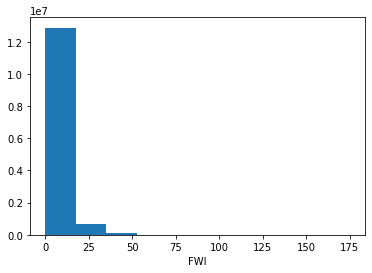

In [4]:
ds.FWI.plot()

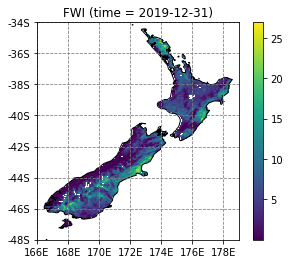

In [6]:
ds.FWI[0,:,:].salem.quick_map()

For the SOM documantiation go to: https://sklearn-som.readthedocs.io/en/latest/. The function below calculates a SOM in m x n dimensions. The shape of the training data must be 2D hence, (time, lat * lon). **The input must be a numpy array and can not contain any NA values.**

In [7]:
# Extract the FWI data
FWI = ds.FWI
# Convert to a Numpy array
ds_np = xr.DataArray.to_numpy(FWI.load())
# Remove all NaN values by selecting an absurdly high number so we can spot it in our results
ds_np_nonan = np.nan_to_num(ds_np, nan = -9999)

In [36]:
def calc_som(m, n, data, learning_rate=1, epochs=1):
    """
    the product of m and n is the amount of nodes (the shape of the plots)
    """
    
    # Extract the lat lon data
    lat_dim = data.shape[1]
    lon_dim = data.shape[2]
    lat_lon_dim = lat_dim*lon_dim
    
    # Build a m x n SOM. lr is the learning rate which you can alter
    som = SOM(m=m, n=n, dim=lat_lon_dim, lr=learning_rate)

    # Fit it to the data. epochs is the amount of times to train the data.
    som.fit(data.reshape((data.shape[0], lat_lon_dim)), epochs=epochs)

    # Assign each datapoint to its predicted cluster
    predictions = som.predict(data.reshape((data.shape[0], lat_lon_dim)))
    return som, predictions

In [13]:
m = 3; n = 3
som, predict_som = calc_som(m, n, ds_np_nonan)

(array([  1.,  20., 338.,   1.,   0.,   1.,   1.,   2.,   0.,   3.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

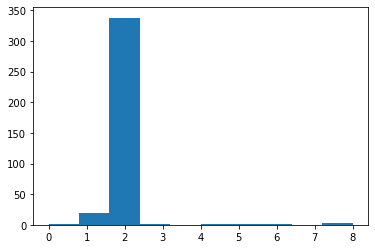

In [10]:
plt.hist(predict_som)

For each SOM node a mean of the FWI is calculated

In [61]:
def plot_som_maps(predict_som, m, n, dataset, **matplotlib_kwargs):

    som_dict = {}
    for node_number in range(0, m*n):
        # As they have the same pattern, then take the mean of them as should be very similar
        mean_FWI = dataset[predict_som == node_number].mean(dim="time")
        som_dict[str(node_number)] = mean_FWI.load()

    proj = dataset.salem.cartopy()
    fig = plt.figure(figsize=[16,12])
    for node_number in range(0, m*n):
        ax = plt.subplot(m, n, node_number+1, projection=proj)
        som_dict[str(node_number)].plot(transform=proj, extend="both", **matplotlib_kwargs)

        ax.coastlines('10m', linewidth=1)
        ax.set_aspect('auto')
        ax.set_extent(dataset.salem.grid.extent, crs=proj)
        ax.gridlines(alpha=0.7)
        plt.tight_layout()


In [ ]:
def plot_som_timeseries(predict_som, dataset):
    plt.figure(figsize=(20, 6))
    plt.plot(dataset.time, predict_som, "o")
    plt.grid(True)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.yticks(np.arange(0, max(predict_som)+1, 1.0))
    plt.xticks(rotation=45)

In [ ]:
plot_som_maps(predict_som, m, n, FWI)

In [ ]:
plot_som_timeseries(predict_som, FWI)

### Assignment 
a) Try to change number of nodes. e.g 4x4 or 2x2. 
What number of nodes works the best? 

b) Play with learning rate and epoch numbers.

In [20]:
m = 4; n = 4
som, predict_som = calc_som(m, n, ds_np_nonan)

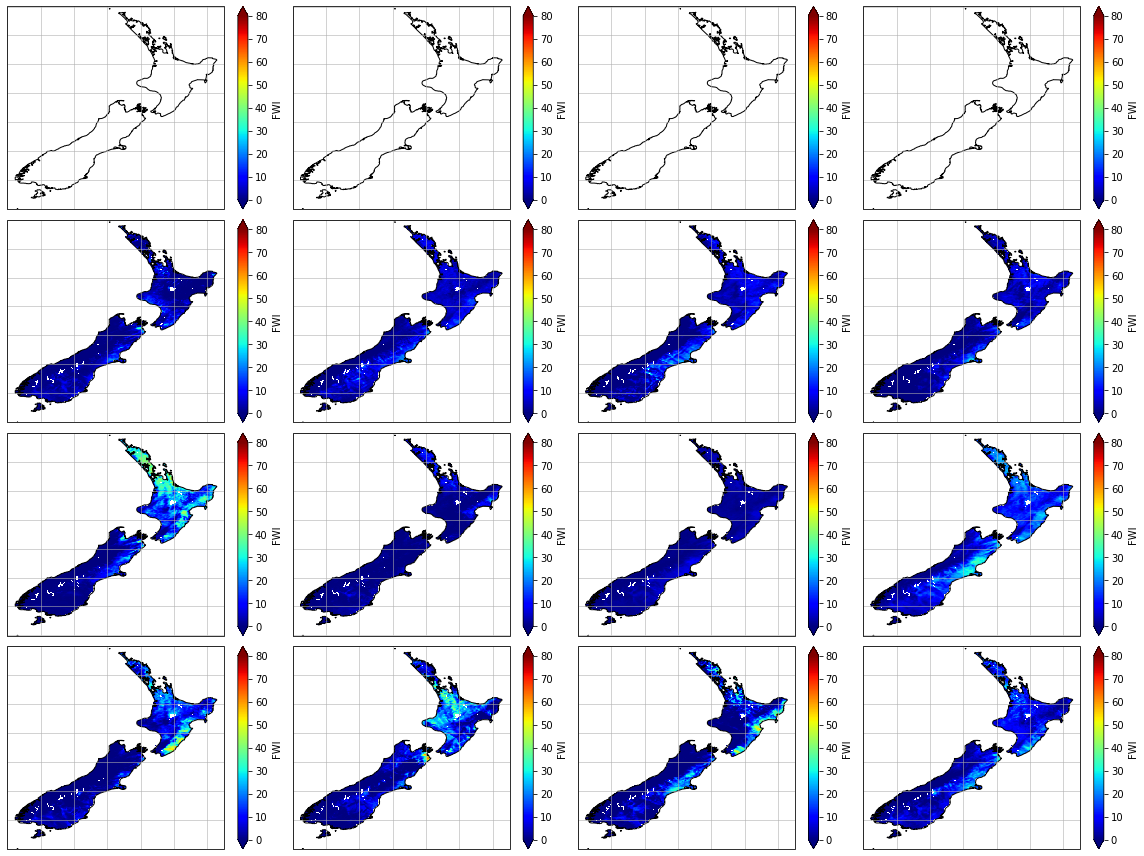

In [22]:
plot_som_maps(predict_som, m, n, FWI)

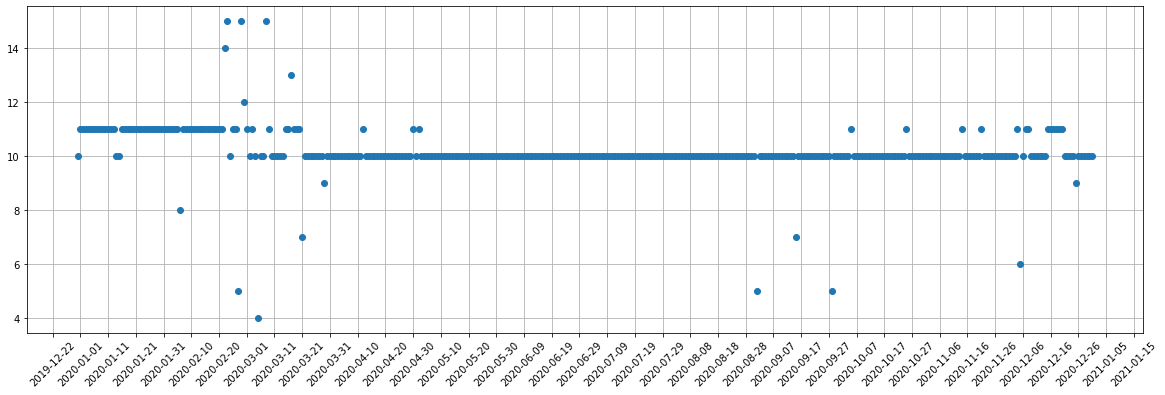

In [25]:
plot_som_timeseries(predict_som, FWI)

And then do 2x2

In [26]:
m = 2; n = 2
som, predict_som = calc_som(m, n, ds_np_nonan)

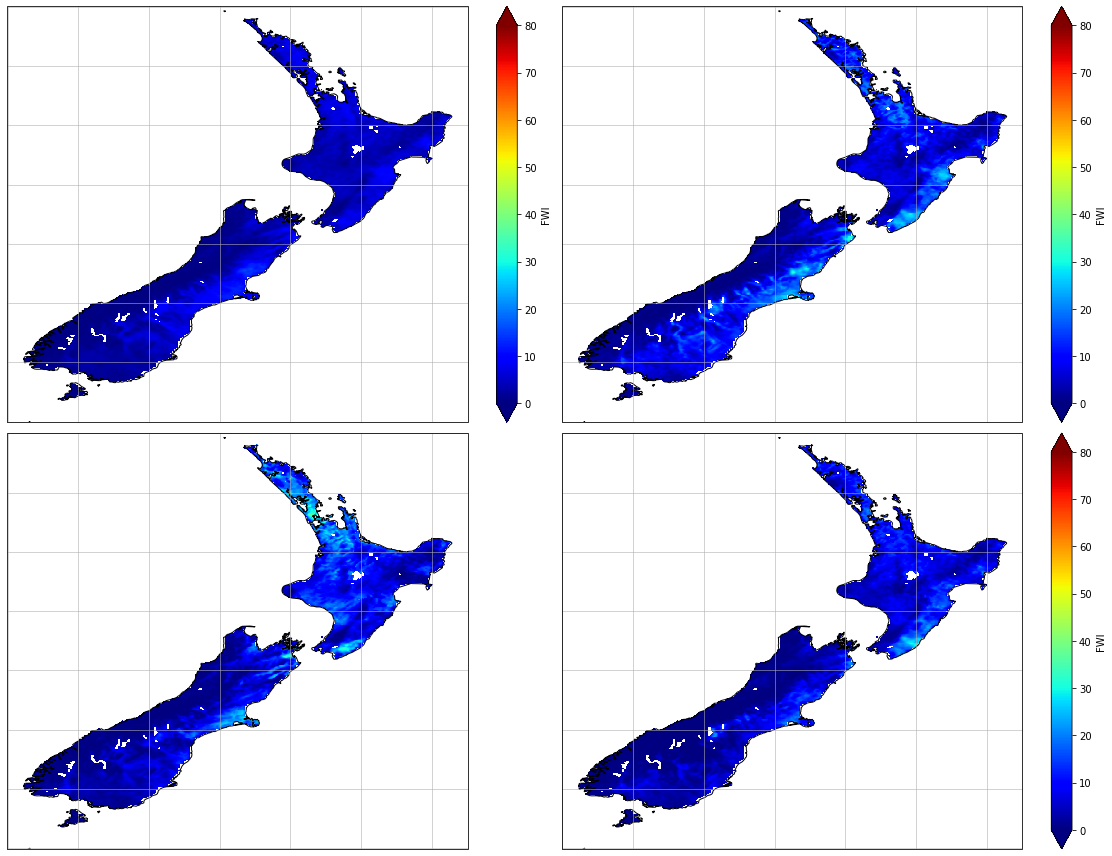

In [27]:
plot_som_maps(predict_som, m, n, FWI)

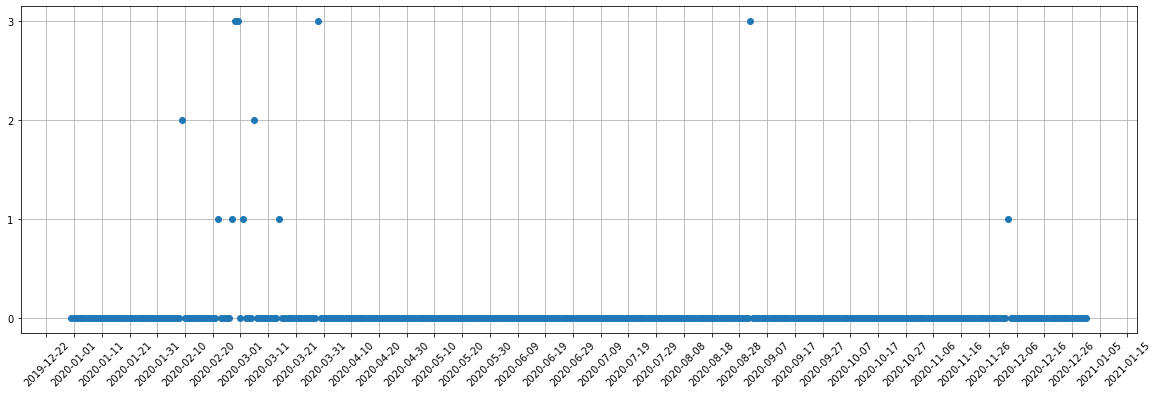

In [34]:
plot_som_timeseries(predict_som, FWI)

In [37]:
m = 3; n = 3; learning_rate = 0.75; epochs = 10
som, predict_som = calc_som(m, n, ds_np_nonan, learning_rate=learning_rate, epochs=epochs)

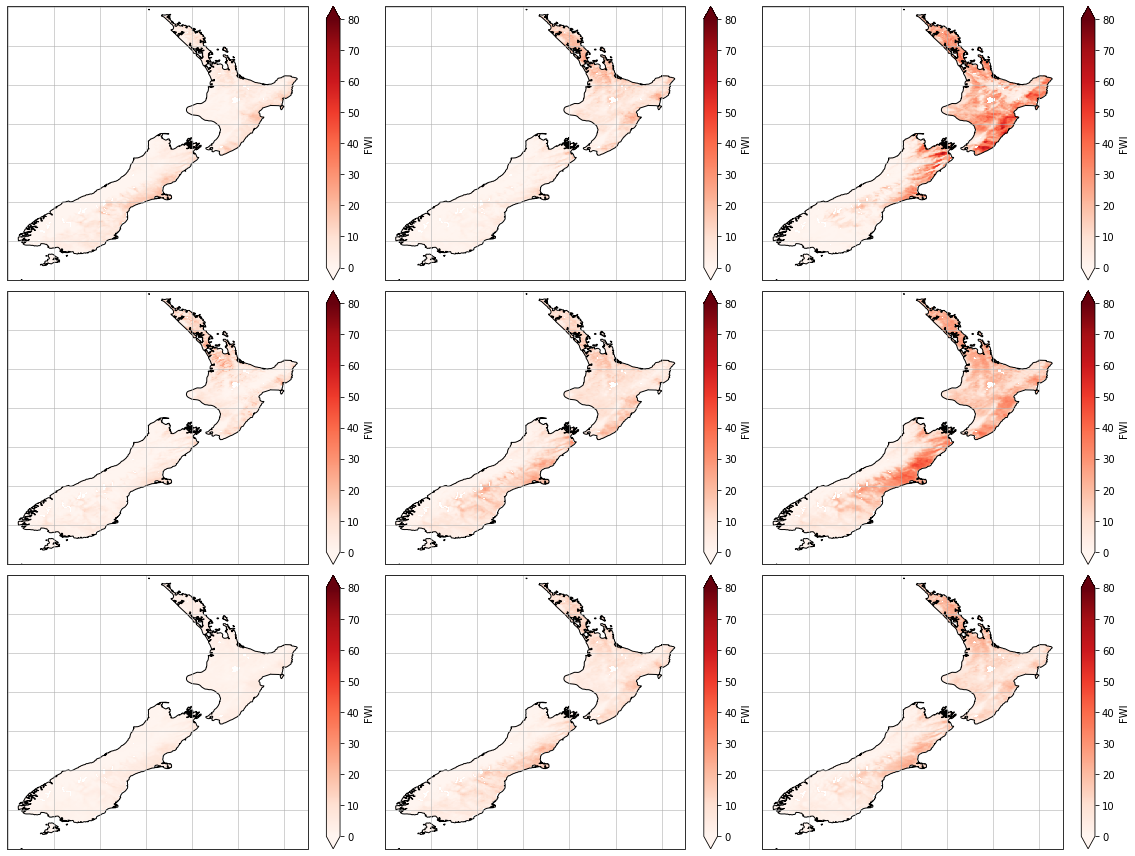

In [49]:
plot_som_maps(predict_som, m, n, FWI)

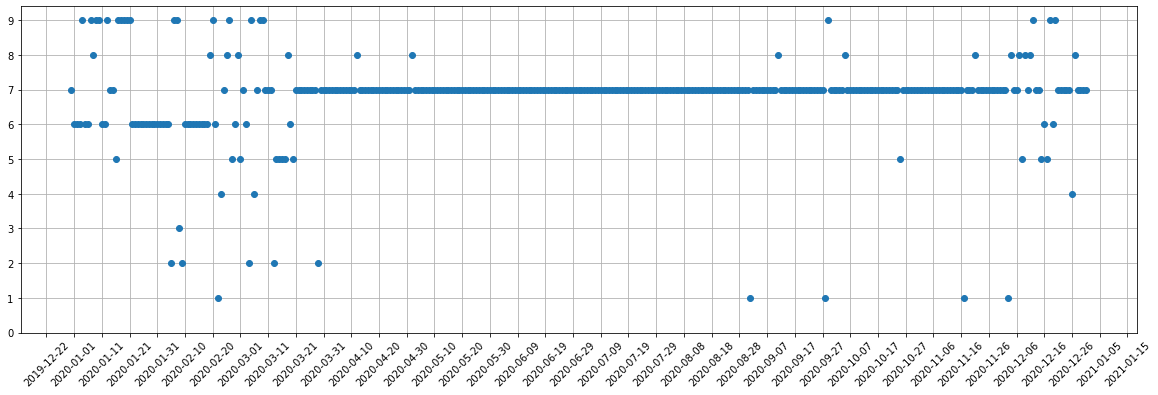

In [53]:
plot_som_timeseries(predict_som+1, FWI)

(array([  5.,   5.,   1.,   3.,   0.,  12.,  36., 269.,  15.,  21.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

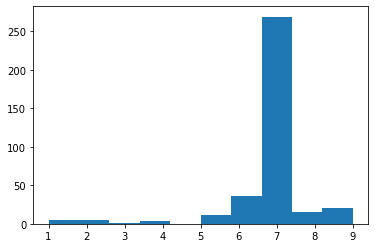

In [52]:
plt.hist(predict_som+1)

### Assignment 
a) With the prefered settings from above, try to create a SOM for one of the other data variables in the nc-fil. e.g. ISI. To save computational time, assume the FWI and ISI are 100% correlated so that instead of running the correlation SOM again, just index the ISI.

In [54]:
ISI = ds.ISI
ISI_np = xr.DataArray.to_numpy(ISI.load())
ISI_np_nonan = np.nan_to_num(ISI_np, nan = -9999)

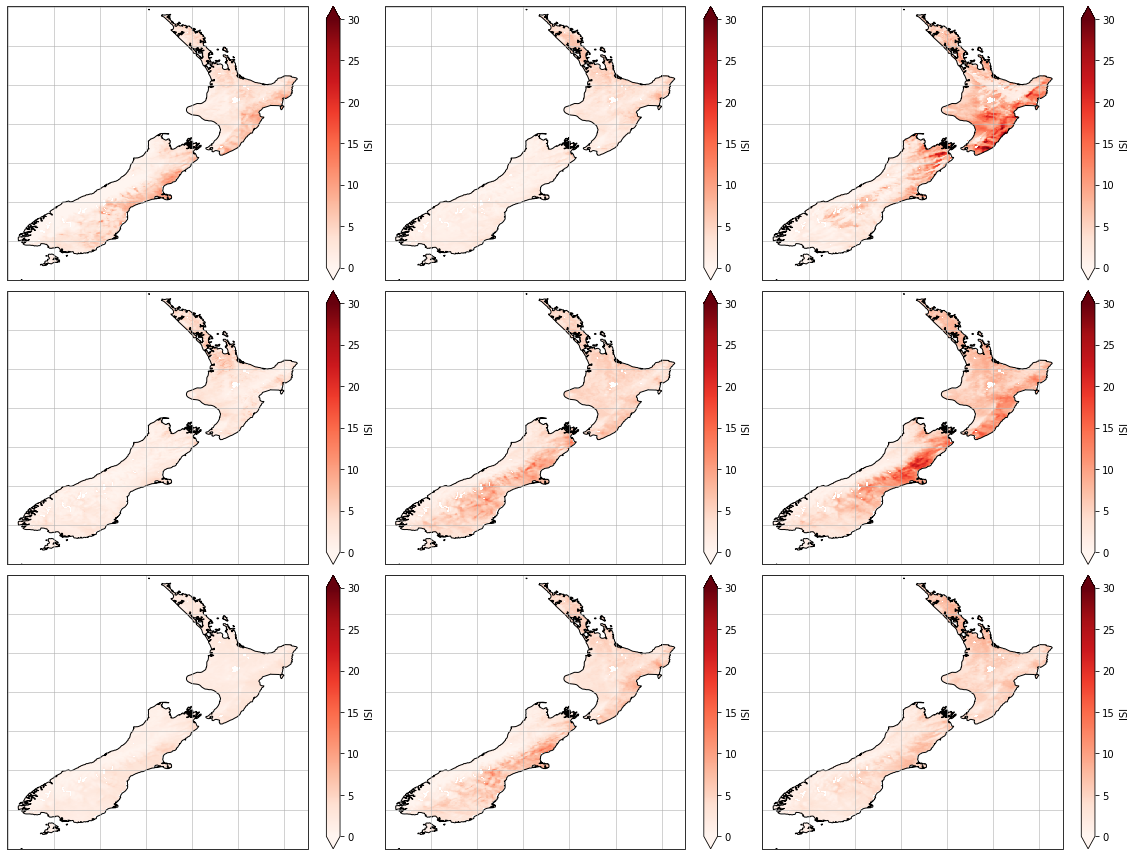

In [64]:
plot_som_maps(predict_som, m, n, ISI, cmap="Reds", vmin=0, vmax=30)